# `MonotonicSplineEpistasis` model
Simulates some variants and analyzes them under the `globalepistasis.MonotonicSplineEpistasis` model.

This notebook is designed as a test, not for user documentation--and it uses some private methods that should not be used in real analyses.

## Set up
Import Python modules:

In [1]:
import cProfile
import math
import pstats
import random
import tempfile
import time
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.globalepistasis
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Parameters for simulations:

In [2]:
seed = 1  # random number seed
genelength = 18  # gene length in codons
bclen = 16  # length of barcodes
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.5  # average codon mutations per variant
variant_error_rate = 0  # rate variants are mis-sequenced
depth = 1000 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.0  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'loose_bottle': variants_per_lib * 1000,
        }

Seed random number generators:

In [3]:
random.seed(seed)
scipy.random.seed(seed)

Suppress warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Set plotnine theme:

In [5]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate variants
Simulate wildtype gene sequence:

In [6]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 18 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTA


Simulate a `CodonVariantTable`:

In [7]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Number of amino-acid mutations per variant in library:

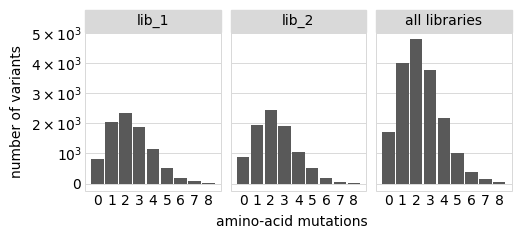

In [8]:
p = variants.plotNumMutsHistogram('aa', samples=None, max_muts=8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Simulate variant counts
We will simulate using a `SigmoidPhenotypeSimulator`:

In [9]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                    geneseq,
                    seed=seed,
                    )

Plot relationship between simulated and observed phenotypes:

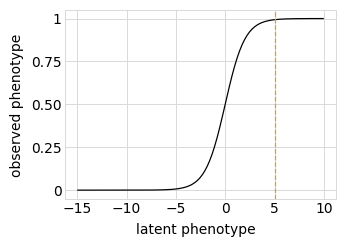

In [10]:
p = phenosimulator.plotLatentVsObserved()
_ = p.draw()

Plot latent and observed phenotypes of all single amino-acid mutants:

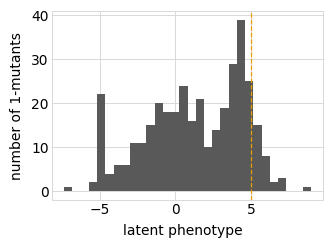

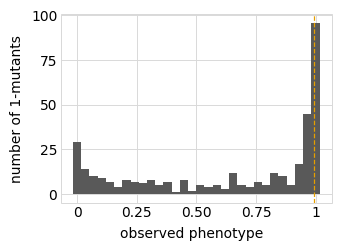

In [11]:
for phenotype in ['latent', 'observed']:
    p = phenosimulator.plotMutsHistogram(phenotype)
    _ = p.draw()

Now we simulate the counts according to the observed phenotype:

In [12]:
counts = dms_variants.simulate.simulateSampleCounts(
            variants=variants,
            phenotype_func=phenosimulator.observedPhenotype,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

Add the counts to the variant table:

In [13]:
variants.add_sample_counts_df(counts)

Confirm expected selection on mutations:

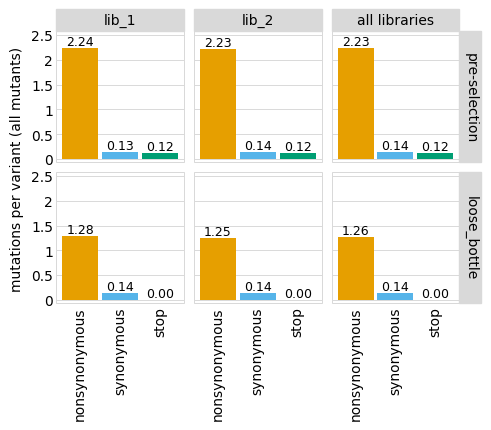

In [14]:
p = variants.plotNumCodonMutsByType('all')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

In [15]:
variants.numCodonMutsByType('all')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,20160471,9000000,2.240052
1,lib_1,pre-selection,synonymous,1190230,9000000,0.132248
2,lib_1,pre-selection,stop,1081015,9000000,0.120113
3,lib_1,loose_bottle,nonsynonymous,11533670,9000000,1.281519
4,lib_1,loose_bottle,synonymous,1222977,9000000,0.135886
5,lib_1,loose_bottle,stop,4300,9000000,0.000478
6,lib_2,pre-selection,nonsynonymous,20028816,9000000,2.225424
7,lib_2,pre-selection,synonymous,1275581,9000000,0.141731
8,lib_2,pre-selection,stop,1060811,9000000,0.117868
9,lib_2,loose_bottle,nonsynonymous,11206791,9000000,1.245199


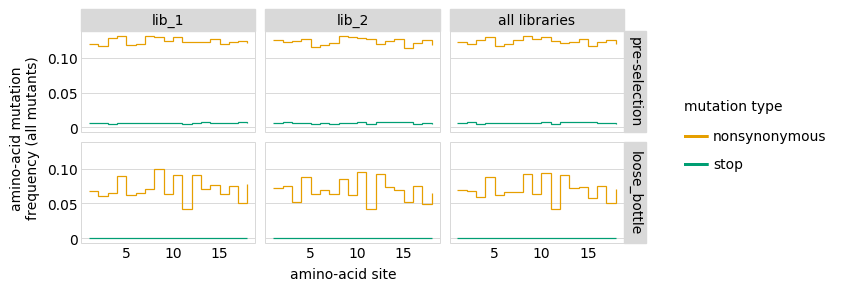

In [16]:
p = variants.plotMutFreqs('all', 'aa')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Get functional scores
Get the functional scores:

In [17]:
func_scores = variants.func_scores('pre-selection', libraries=variants.libraries)

Classify the functional scores:

In [18]:
func_scores = variants.classifyVariants(func_scores)

Use `plotnine` to plot distribution of functional scores:

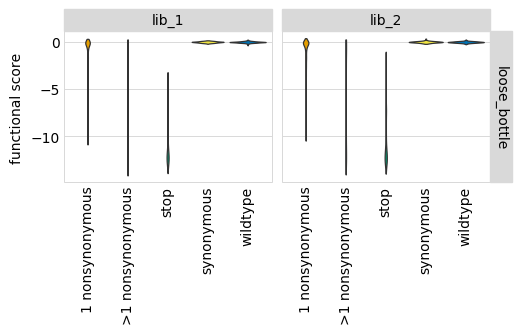

In [19]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs),
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Initialize model

Make a binary map for the variants:

In [20]:
binarymap = dms_variants.binarymap.BinaryMap(func_scores)
print(f"Length of binary map is {binarymap.binarylength}")

Length of binary map is 360


Now initialize the model:

In [21]:
spline_model = dms_variants.globalepistasis.MonotonicSplineEpistasis(binarymap)

Look at some model attributes:

In [22]:
spline_model.nparams

368

In [23]:
spline_model.epistasis_HOC

1.0

In [24]:
round(spline_model.loglik)

-959253.0

In [25]:
spline_model.latent_phenotype_wt

0.0

In [26]:
for key, val in spline_model.epistasis_func_params_dict.items():
    print(f"{key}: {round(val, 2)}")

c_alpha: -14.18
alpha_1: 2.92
alpha_2: 2.92
alpha_3: 2.92
alpha_4: 2.92
alpha_5: 2.92


Check the analytical gradient versus numerical approximation, and make sure the difference is small compared to total gradient:

In [27]:
err = scipy.optimize.check_grad(
            spline_model._loglik_by_allparams,
            spline_model._dloglik_by_allparams,
            spline_model._allparams)
tot = math.sqrt(sum(spline_model._dloglik_by_allparams(spline_model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

## Fit model
Perform initial least squares optimization followed by rescaling latent effects (normally this is actually performed by the `fit` method):

In [28]:
spline_model._fit_latent_leastsquares()
spline_model._prescale_params()

Re-check the gradients:

In [29]:
err = scipy.optimize.check_grad(
            spline_model._loglik_by_allparams,
            spline_model._dloglik_by_allparams,
            spline_model._allparams)
tot = math.sqrt(sum(spline_model._dloglik_by_allparams(spline_model._allparams)**2))
if err / tot > 1e-3:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

Print model parameters after this "partial" fitting:

In [30]:
round(spline_model.loglik)

-52098.0

In [31]:
round(spline_model.epistasis_HOC, 3)

2.909

In [32]:
round(spline_model.latent_phenotype_wt, 3)

0.899

Now fit the model by maximum likelihood, also profiling [as here](https://stackoverflow.com/a/1584468):

In [33]:
# NBVAL_IGNORE_OUTPUT
start = time.time()
profiler = cProfile.Profile()
optres = profiler.runcall(spline_model.fit)
optres = spline_model.fit()
print(f"Fitting took {time.time() - start:.3f} seconds")
print(f"Iterations: {optres.nit}.\n"
      f"Function evaluations: {optres.nfev}\n"
      f"Termination message: {optres.message}")

Fitting took 20.831 seconds
Iterations: 593.
Function evaluations: 703
Termination message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Look at some of the model parameters after optimization:

In [34]:
round(spline_model.loglik)

-869.0

In [35]:
round(spline_model.epistasis_HOC, 3)

0.005

In [36]:
round(spline_model.latent_phenotype_wt, 3)

0.0

In [37]:
spline_model._mesh.round(2)

array([-7.98, -5.55, -3.13, -0.71])

In [38]:
spline_model.alpha_ms.round(2)

array([0.000e+00, 0.000e+00, 1.000e-02, 1.272e+01, 3.000e-02])

In [39]:
round(spline_model.c_alpha, 2)

-12.79

Plot correlation of actual functional scores with latent and observed phenotypes:


Correlation for latent:
R = 0.913, P = 0

Correlation for observed:
R = 0.994, P = 0


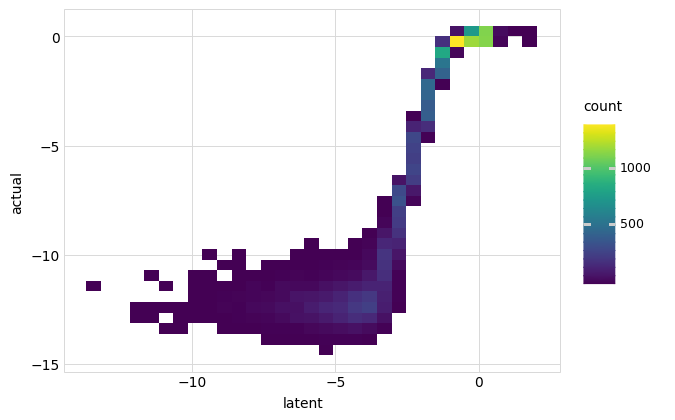

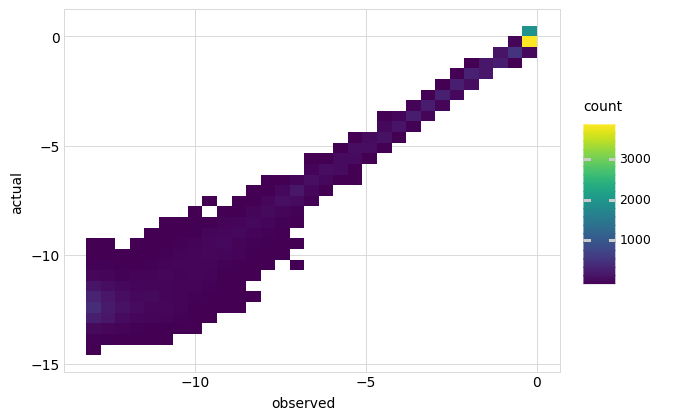

In [40]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'latent': spline_model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'latent'),
                   'observed': spline_model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'observed'),
                   })

for phenotype in ['latent', 'observed']:
    r, p = scipy.stats.pearsonr(
        binarymap.func_scores,
        spline_model.phenotypes_frombinary(binarymap.binary_variants, phenotype)
        )
    print(f"\nCorrelation for {phenotype}:\nR = {r:.3f}, P = {p:.2g}")

    _ = (ggplot(df, aes(phenotype, 'actual')) +
         geom_bin2d()
         ).draw()

Plot latent versus observed phenotypes:

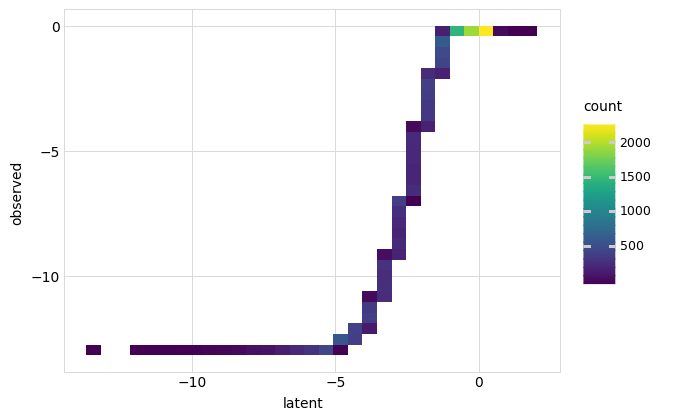

In [41]:
_ = (ggplot(df, aes('latent', 'observed')) +
     geom_bin2d()
     ).draw()

Look at profiling results:

In [42]:
# NBVAL_IGNORE_OUTPUT
with tempfile.NamedTemporaryFile('w') as f:
    profiler.dump_stats(f.name)
    f.flush()
    stats = pstats.Stats(f.name).strip_dirs()
for stat in ['cumtime', 'tottime']:
    print(stats.sort_stats(stat).print_stats(20))

Mon Oct 28 05:45:31 2019    /tmp/tmpvvouc1l_

         3441968 function calls (3105812 primitive calls) in 7.437 seconds

   Ordered by: cumulative time
   List reduced from 342 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    7.437    7.437 globalepistasis.py:631(fit)
        1    0.000    0.000    7.400    7.400 _minimize.py:42(minimize)
        1    0.031    0.031    7.400    7.400 lbfgsb.py:211(_minimize_lbfgsb)
      362    0.002    0.000    7.368    0.020 lbfgsb.py:284(func_and_grad)
173188/1087    0.157    0.000    5.916    0.005 methodtools.py:31(__call__)
     1087    0.194    0.000    5.911    0.005 ispline.py:247(_calculate_Itotal_or_dItotal)
     7225    0.359    0.000    5.291    0.001 ispline.py:673(_calculate_I_or_dI)
      362    0.001    0.000    4.394    0.012 optimize.py:324(function_wrapper)
      362    0.001    0.000    4.393    0.012 globalepistasis.py:685(_loglik_by_allparams)
 

## Examine results
Correlation of predicted and actual predicted latent effects.
Get a data frame of the latent effects of all single mutations:

In [65]:
singles_df = spline_model.latent_effects_df
singles_df.head()

,mutation,latent_effect
0,R1*,-2.619536
1,R1A,-1.808556
2,R1C,-0.251183
3,R1D,-0.403747
4,R1E,-2.340180


Add the true latent effects from the simulator:

In [66]:
singles_df = (
    singles_df
    .rename(columns={'mutation': 'aa_substitutions'})
    .assign(true_latent_effect=lambda x: x['aa_substitutions'].map(phenosimulator.muteffects))
    )
singles_df.head()

,aa_substitutions,latent_effect,true_latent_effect
0,R1*,-2.619536,-10.000000
1,R1A,-1.808556,-7.005432
2,R1C,-0.251183,-0.948878
3,R1D,-0.403747,-1.605935
4,R1E,-2.340180,-9.136289


Now add the predicted and true latent and observed phenotypes:

In [77]:
singles_df = spline_model.add_phenotypes_to_df(singles_df)

singles_df = (
    singles_df
    .assign(true_latent_phenotype=lambda x: x.apply(phenosimulator.latentPhenotype, axis=1),
            true_enrichment=lambda x: x.apply(phenosimulator.observedPhenotype, axis=1),
            enrichment=lambda x: 2**x['observed_phenotype'],
            true_observed_phenotype=lambda x: scipy.log(x['true_enrichment']) / scipy.log(2)
            )
    )

ValueError: `df` already contains column latent_phenotype

In [78]:
singles_df

,aa_substitutions,latent_effect,true_latent_effect,latent_phenotype,observed_phenotype,true_latent_phenotype,true_observed_phenotype,true_enrichment,enrichment
0,R1*,-2.619536,-10.000000,-2.619536,-7.253118,-5.000000,-7.223163,0.006693,0.006555
1,R1A,-1.808556,-7.005432,-1.808556,-3.100184,-2.005432,-3.075413,0.118634,0.116614
2,R1C,-0.251183,-0.948878,-0.251183,-0.035499,4.051122,-0.024891,0.982895,0.975694
3,R1D,-0.403747,-1.605935,-0.403747,-0.035499,3.394065,-0.047639,0.967519,0.975694
4,R1E,-2.340180,-9.136289,-2.340180,-5.803062,-4.136289,-5.990278,0.015731,0.017910
...,...,...,...,...,...,...,...,...,...
355,L18S,-0.828028,-3.210801,-0.828028,-0.084967,1.789199,-0.222921,0.856829,0.942806
356,L18T,-1.633275,-6.355319,-1.633275,-2.306970,-1.355319,-2.286289,0.205002,0.202084
357,L18V,-0.377215,-1.474252,-0.377215,-0.035499,3.525748,-0.041845,0.971412,0.975694
358,L18W,-1.617924,-6.310052,-1.617924,-2.241226,-1.310052,-2.234614,0.212478,0.211507


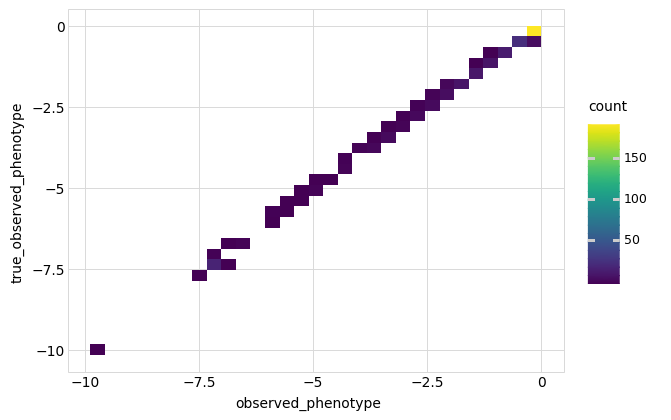

<ggplot: (8748278167763)>

In [79]:
ggplot(singles_df, aes('observed_phenotype', 'true_observed_phenotype')) + geom_bin2d()

Look at correlation among all fit variants:

In [81]:
variants_df = spline_model.phenotypes_df

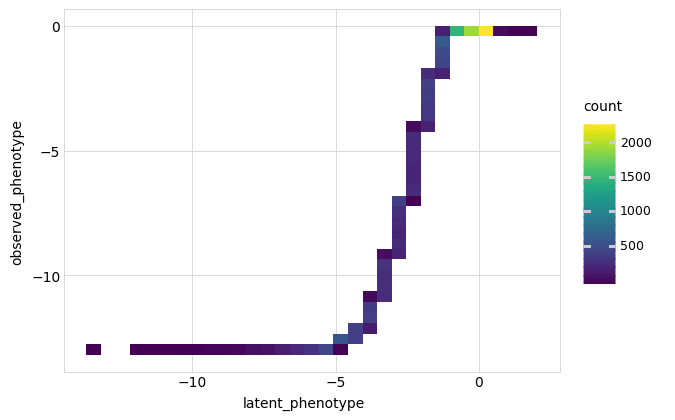

<ggplot: (-9223363288573098089)>

In [85]:
ggplot(variants_df, aes('latent_phenotype', 'observed_phenotype')) + geom_bin2d()